# CPSC 479/579 Assignment 2: Face Warping

The goal of this assignment is to automatically create morphing video transitions between faces, similar to
Michael Jackson’s Black or White: https://youtu.be/n5b_nIzdvfI.

We will first construct a few building blocks such as an image warper and a face landmark detector. Later we will combine all the building blocks to create the final program.

## Raw footage
Record several sequences of similar head motion across different people. The head should take up most of
the frame, and the background should be a uniform color.

## Final Deliverables
Your final submission should include:
* Raw video footage.
* Video morphing results.
* A working implementation. Running the Jupyter notebook should generate all results with no errors.

In [1]:
! pip install scipy dlib opencv-python matplotlib

In [2]:
# Initialize all imports

import numpy as np
import cv2
import matplotlib.pyplot as plt

from warp_image import ImageWarper
from detect_landmarks import FaceLandmarkDetector
from extrapolate_vector_field import Extrapolator
from warp_face import generate_face_warp_video

## Warp an image using a dense vector field

In `warp_image.py`, implement the missing pieces of the `ImageWarper` class. The code below should produce a test image, shifted 50 pixels to the left and 200 pixels upwards (padded with black pixels):
![Warped test pattern](./expected_results/test-pattern-warped.png "Warped test pattern")

Useful functions:
[cv2.remap](https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/remap/remap.html)
[numpy.mgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mgrid.html)

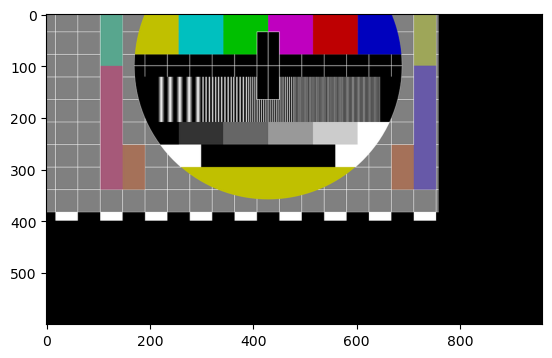

In [3]:
# Input filename
f = './data/test-pattern.png'

# Read image
img = cv2.imread(f)
img_size = img.shape[0:2]

# Construct an ImageWarper object
w = ImageWarper()

# Generate warp field. Values x and y in location (row, col) mean that in the final output, pixel (row, col)
# should be sampled from (row, col) + (y, x)
warp_field_x = np.full(img_size, 50)
warp_field_y = np.full(img_size, 200)

# Warp image
img_warped = w.warp(img, warp_field_x, warp_field_y)

plt.imshow(img_warped[..., ::-1]) # convert from BGR (opencv) to RGB (matplotlib)
plt.show()

# Note that we specified a constant warp field for all pixels. However, your function must work with 
# arbitrary warp fields. Add more test cases to make sure everything works as expected.

## Detect face landmarks

Our goal is to warp faces to each other. In order to do that we will use face landmarks: the location of prominent features such as eyes, nose and mouth.

In `detect_landmarks.py`, implement the missing pieces of the `FaceLandmarkDetector` class. The code below should display 68 detected landmarks, overlaid on the face:
![Face landmarks](./expected_results/landmarks.png "Face landmarks")

You may assume that there's only one face in the photo.

Useful functions:
[dlib.get_frontal_face_detector](http://dlib.net/python/index.html#dlib.get_frontal_face_detector)
[dlib.shape_predictor](http://dlib.net/python/index.html#dlib.shape_predictor)

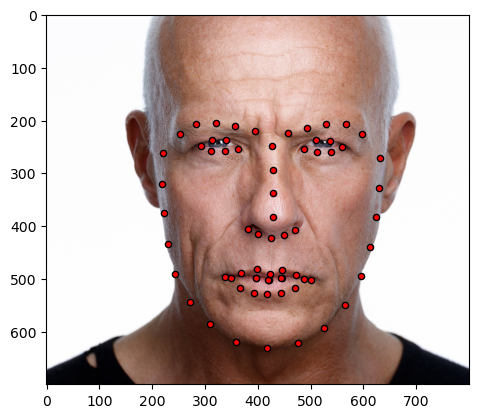

In [4]:
face_filename = './data/head1.jpg'
face = cv2.imread(face_filename)

d = FaceLandmarkDetector()
landmarks = d.predict(face)

d.plot_landmarks(face, landmarks)

## Extrapolate vector field

Given two sets of face landmarks we can construct a sparse vector field from one to the other. However, for our image warping code, we require a dense vector field. 

In `extrapolate_vector_field.py`, implement the missing pieces of the `Extrapolator` class. The generated vector field should be an interpolation of the sparse one. You will also need to make sure image boundaries are stationary, by adding zero-length vectors to the sparse field on image boundaries.

Useful functions:
[scipy.interpolate.griddata](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html)

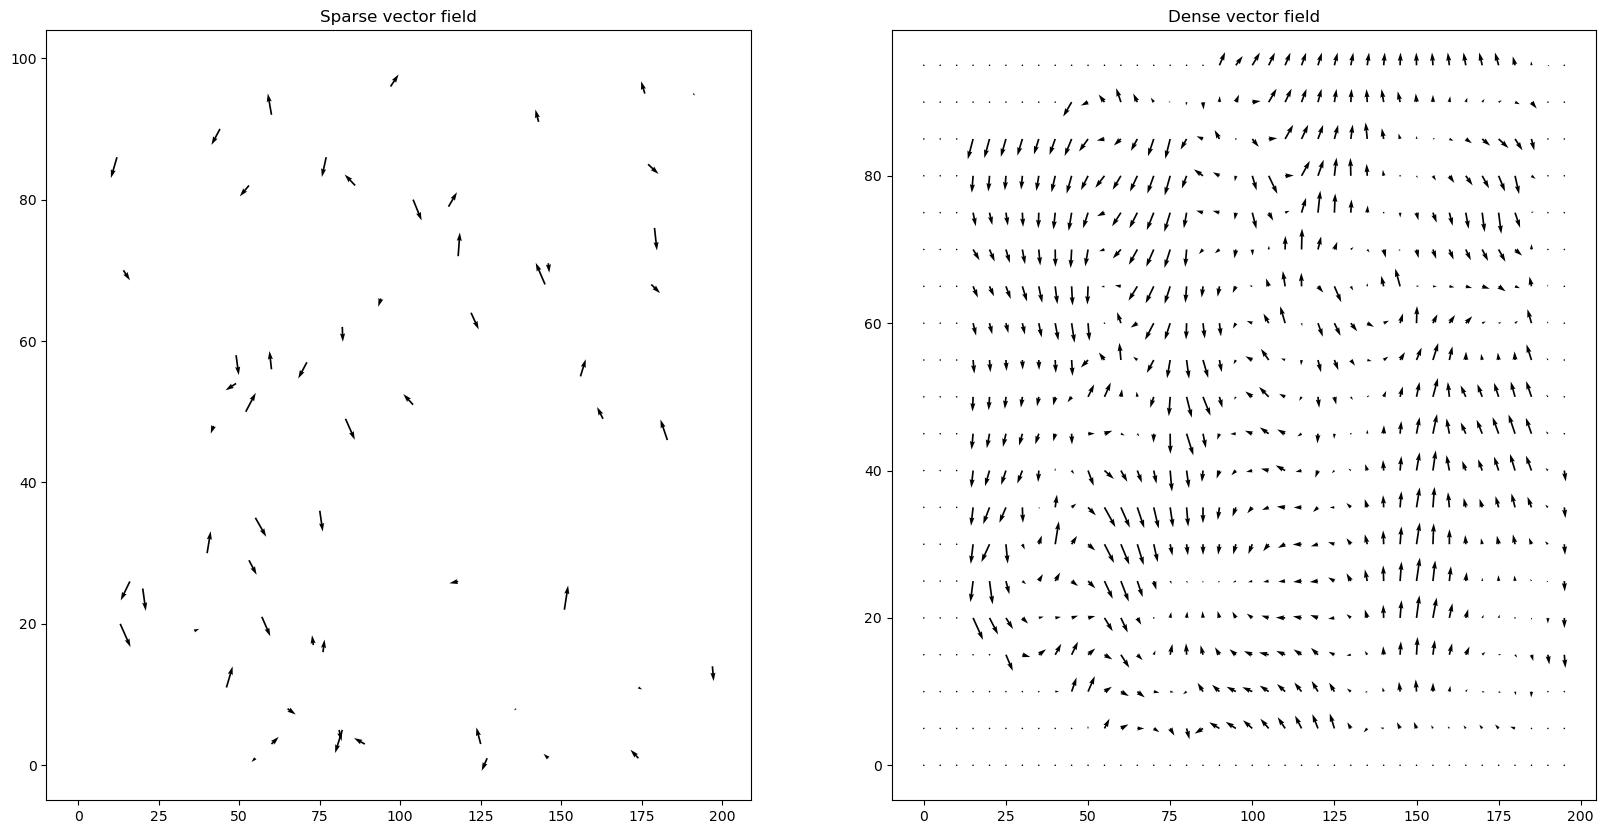

In [5]:
img_size = [100, 200]

e = Extrapolator()

# Generate a random sparse vector field
n_samples = 60
max_val = 7
row = np.random.randint(img_size[0], size=[n_samples])
col = np.random.randint(img_size[1], size=[n_samples])
data_x = np.random.rand(n_samples) * max_val - (max_val / 2)
data_y = np.random.rand(n_samples) * max_val - (max_val / 2)

# Plot the sparse vector field
x_orig = np.full(img_size, np.nan)
y_orig = np.full(img_size, np.nan)
x_orig[row, col] = data_x
y_orig[row, col] = data_y
fig = plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('Sparse vector field')
e.plot_vector_field(x_orig, y_orig, show_plot=False)

# Generate a dense vector field from the sparse one
x, y = e.extrapolate(col, row, data_x, data_y, img_size)

# Plot the dense vector field
plt.subplot(1, 2, 2)
plt.title('Dense vector field')
e.plot_vector_field(x, y, step=5)

# You might want to add more test cases with non-random data, to make sure everything works as expected

## Generate face morphing video

Implement `generate_face_warp_video()` in `warp_face.py`. The function accepts filenames of two face photos, and an output video filename. It also optionally accepts the number of video frames to generate and the video frame rate.

You will need to use functions you created above in order to generate the video. Specifically, you should be able to create a hybrid face, which is $\alpha$ away from face1 and $1 - \alpha$ away from face2. The hybrid is created by warping face1 towards face2 in the appropriate amount, and also warping face2 towards face1 in the appropriate amount. The final frame is $\alpha$-blending of the two warped faces.

The warp field should be derived from face landmark locations. Notice that you might want to be selective here and only use some but not all of the landmarks.

To produce the complete video, you will generate `n_frames` such frames with varying $\alpha$. Your result should be similar to `./expected_results/out.mp4`.

In [6]:
face1_filename = './data/head1.jpg'
face2_filename = './data/head2.jpg'
out_filename = './data/out.mp4'

generate_face_warp_video(face1_filename, face2_filename, out_filename)

## Generate transitions between two videos

Now that you can morph one face to another, it is time to move from photos to videos. 
Record two (or more) videos of different people performing various head motions. For best results, make sure the heads are clearly visible and that the background is uniform.
Pick sequences that will make a good transition (e.g. both people performing the same motion) and produce a morph between them. 

For this final step you are on your own &mdash; no template given. Make sure your results are well organized, and clearly write their location below.